## Usecase 7 - Response latencies
Replication of Figure 20 A3 from "Reconstruction and Simulation of Neocortical Microcircuity". We compute the mean spike response latencies over 50 trials for each neuron, and plot them depending on the layer they are in.

First, we import numpy and pyplot which we will need later for analysis and plotting.

In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

from bluepy import Simulation, Circuit, Cell

# disable warning for bluepy-configfile because it noises output and functional tests fail because of it
import logging
import bluepy_configfile
logger = logging.getLogger(bluepy_configfile.__name__)
logger.setLevel(logging.ERROR)


path = "/gpfs/bbp.cscs.ch/project/proj1/simulations//ReNCCv3/InVivo/03_Reyes-Puerta/K5p0/Ca1p25/minicols60/seed{}/BlueConfig"

# Can be changed, maximum 50 (in the paper 200 trials are used)
n_trials = 4
simulations = [ Simulation(path.format(n)) for n in range(n_trials)]

circuit = simulations[0].circuit

We want different mean-latency boxplots for layers 2, 3, 4, 5 and 6. 

In [2]:
layers = list(range(2,7))
layer_labels = list(map(lambda x: 'L_{}'.format(x), layers))
n_bins = len(layers)

We set the time of the stimulus, and the latest spike time to be included in the latency (t_max).

In [3]:
t_stim = 1500
t_max = 1530

We run the computation twice, once for excitatory neurons and once for inhibitory:

The mean latencies of each (spiking) cell are now stored in mean_latencies, one list for each layer/bin.

In [4]:
def mean_latencies(synapse_class):
    bin_gids = {}
    for i, layer in enumerate(layers):
        bin_gids[i] = circuit.cells.ids({
            Cell.LAYER: layer,
            Cell.SYNAPSE_CLASS: synapse_class,
            Cell.HYPERCOLUMN: 2
        })
        print("Found {} gids in {}".format(len(bin_gids[i]), layer_labels[i]))
    latencies = [defaultdict(list) for _ in range(n_bins)]
    
    # Now load spikes for each trial
    for sim in simulations:
        for i in range(n_bins):
            spikes = sim.spikes.get(gids=bin_gids[i], t_start=t_stim, t_end=t_max)
            for gid, time in spikes.groupby(spikes).groups.items():
                latencies[i][gid].append(time[0] - t_stim)
                
    result = [
        [np.mean(dts) for dts in bin_latencies.values()]
        for bin_latencies in latencies
    ]
    return result

mean_latencies_exc = mean_latencies('EXC')
mean_latencies_inh = mean_latencies('INH')

Found 2421 gids in L_2
Found 3456 gids in L_3
Found 4178 gids in L_4
Found 5050 gids in L_5
Found 11462 gids in L_6
Found 994 gids in L_2
Found 653 gids in L_3
Found 478 gids in L_4
Found 1064 gids in L_5
Found 1252 gids in L_6


We can have access to layers' boundaries using cells and store them in the `boundaries` variable.

In [5]:
def get_layer_boundaries():
    boundaries = list()
    for layer in layers:
        positions = circuit.cells.get({Cell.LAYER: layer, Cell.HYPERCOLUMN: 2}, properties=[Cell.Y])
        boundaries.append((positions[Cell.Y].min(), positions[Cell.Y].max()))
    return boundaries

boundaries = get_layer_boundaries()
for i, layer in enumerate(layer_labels):
    print('Layer {} between {} and {}'.format(layer, boundaries[i][0], boundaries[i][1]))    

Layer L_2 between 1767.953814 and 1916.657187
Layer L_3 between 1415.021975 and 1767.73165
Layer L_4 between 1225.448599 and 1414.995941
Layer L_5 between 700.526426 and 1225.325908
Layer L_6 between 0.002338 and 700.335378


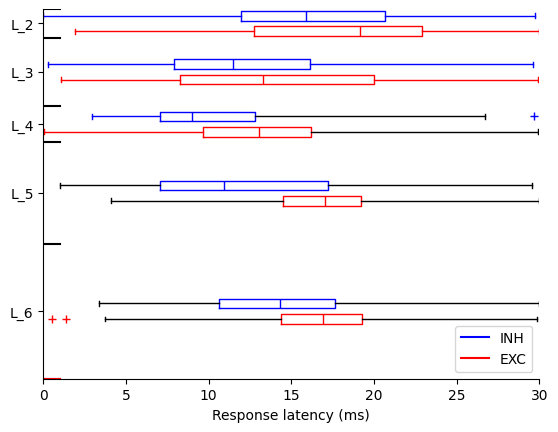

In [6]:
bin_starts = [x[0] for x in boundaries]
bin_ends = [x[1] for x in boundaries]

fig, ax = plt.subplots()

# Positions for boxplots
positions_exc = [(bin_starts[i]+bin_ends[i])/2-40 for i in range(0,5)]
positions_inh = [(bin_starts[i]+bin_ends[i])/2+40 for i in range(0,5)]

# Function for setting the colors of the box plots
def set_box_colors(bp, color):
    for i in range(len(positions_exc)):
        plt.setp(bp['boxes'][i], color=color)
        plt.setp(bp['caps'][i], color=color)
        plt.setp(bp['whiskers'][i], color=color)
        plt.setp(bp['fliers'][i], color=color)
        plt.setp(bp['medians'][i], color=color)

# Plotting the boxplots
bp = ax.boxplot(mean_latencies_exc, vert=False, positions=positions_exc, sym='r+', whis=2.5, widths=50) 
set_box_colors(bp,'red')
bp = ax.boxplot(mean_latencies_inh, vert=False, positions=positions_inh, sym='b+', whis=2.5, widths=50)
set_box_colors(bp,'blue')

# Generating the legend 
inh, = ax.plot([1,1],'b-')
exc, = ax.plot([1,1],'r-')
ax.legend((inh, exc), ('INH', 'EXC'), loc='lower right')

# Figure layout
y_ticks = [(bin_starts[i]+bin_ends[i])/2 for i in range(0,5)]
for bin_end in bin_ends:
    ax.plot((-1, 1),(bin_end,bin_end),'k-')
ax.set_yticks(y_ticks)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_yticklabels(layer_labels)
ax.set_ylim((0,bin_ends[0]))
ax.set_xlim((0, 30))
ax.set_xlabel('Response latency (ms)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [7]:
plt.close('all')